In [99]:
%matplotlib inline
import sys
import glob
import os
import random
import json
import pickle
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from astropy.table import Table
import rubin_sim.maf.db as db
sys.path.append(os.path.abspath(".."))
from local_opsdb_patch import OpsimDatabase #local
from rubin_sim import maf
from rubin_sim.maf.utils import m52snr
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.plots as plots

import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metric_bundles as metric_bundles
from astropy.cosmology import z_at_value
from rubin_sim.maf.metrics import BaseMetric
from rubin_sim.maf.slicers import UserPointsSlicer
from rubin_sim.maf.metric_bundles import MetricBundle, MetricBundleGroup
from rubin_sim.maf.db import ResultsDb
import rubin_sim.maf.utils as maf_utils
import rubin_sim.maf.metrics as metrics
from rubin_sim.maf.plots import HealpixSkyMap
import rubin_sim.maf.plots as plots

#from rubin_sim.utils import equatorialFromGalactic, hpid2RaDec, _healbin, healbin
from astropy.coordinates import Galactic, ICRS
import astropy.units as u
import healpy as hp
from matplotlib.lines import Line2D


from rubin_sim.phot_utils import DustValues

dust_model = DustValues()
#from rubin_sim.utils import getPackageDir
from importlib import resources

def getPackageDir(pkg_name):
    try:
        return resources.files(pkg_name).parent
    except Exception as e:
        raise RuntimeError(f"Could not find package {pkg_name}: {e}")

In [101]:
import sys
import importlib

# Clear the module from cache
if "local_LFBOT_metric" in sys.modules:
    del sys.modules["local_LFBOT_metric"]

# Re-import and reload the updated module
import local_LFBOT_metric
importlib.reload(local_LFBOT_metric)

# Import updated classes and functions from the refactored module
from local_LFBOT_metric import (
    LFBOT_LC,
    generateLFBOTPopSlicer,
    LFBOTDetectMetric,
    LFBOTCharacterizeMetric,
    generateLFBOTTemplates,
    LFBOTSingleFilterDetectMetric
)


# Confirm path
print(local_LFBOT_metric.__file__)

import inspect
print("🔍 using generateLFBOTPopSlicer from:", inspect.getfile(generateLFBOTPopSlicer))



/Users/andradenebula/Documents/Research/Transient_Metrics/Multi_Transient_Metrics_Hub/LFBOT/local_LFBOT_metric.py
🔍 using generateLFBOTPopSlicer from: /Users/andradenebula/Documents/Research/Transient_Metrics/Multi_Transient_Metrics_Hub/LFBOT/local_LFBOT_metric.py



--- Running four_roll_v4.3.1_10yrs ---
Out of 452770 simulated LFBOT events, Rubin detected 308101 under the four_roll_v4.3.1_10yrs cadence.
Of those, each event was observed in an average of 2.0 ± 0.0 filters.


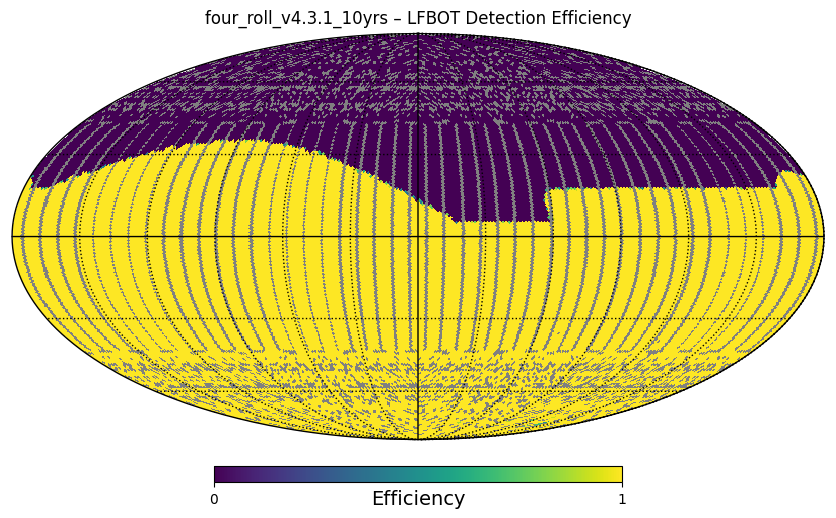

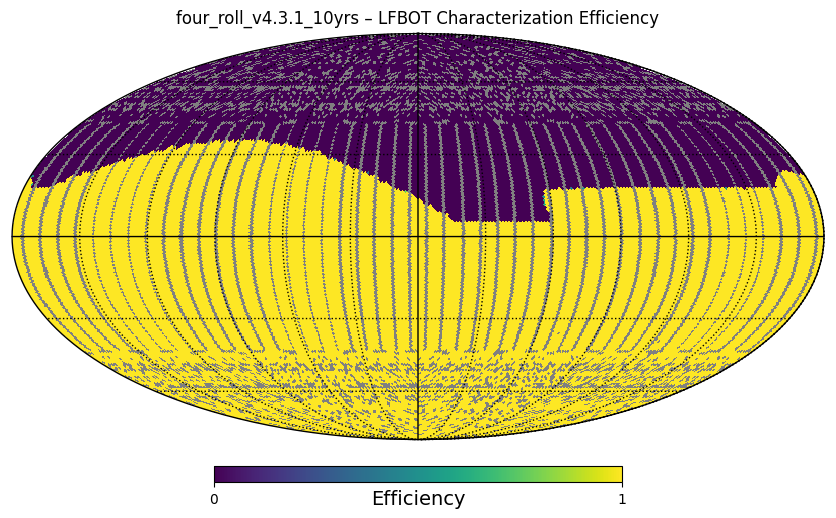

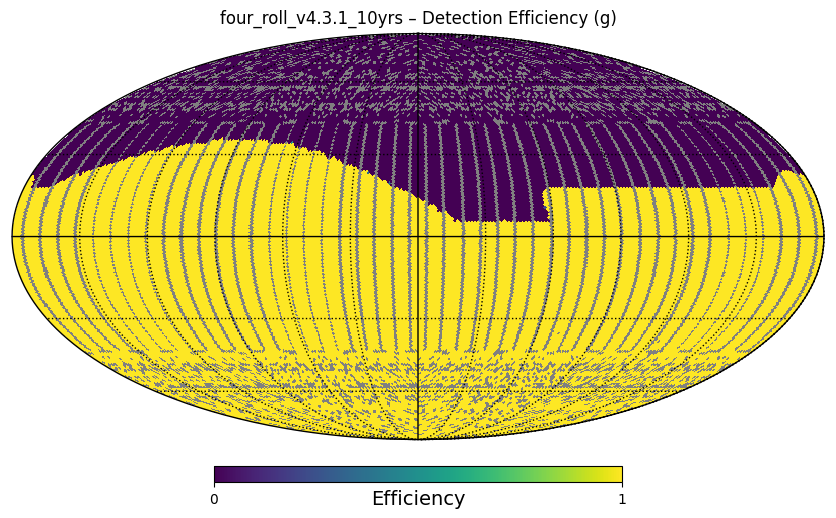

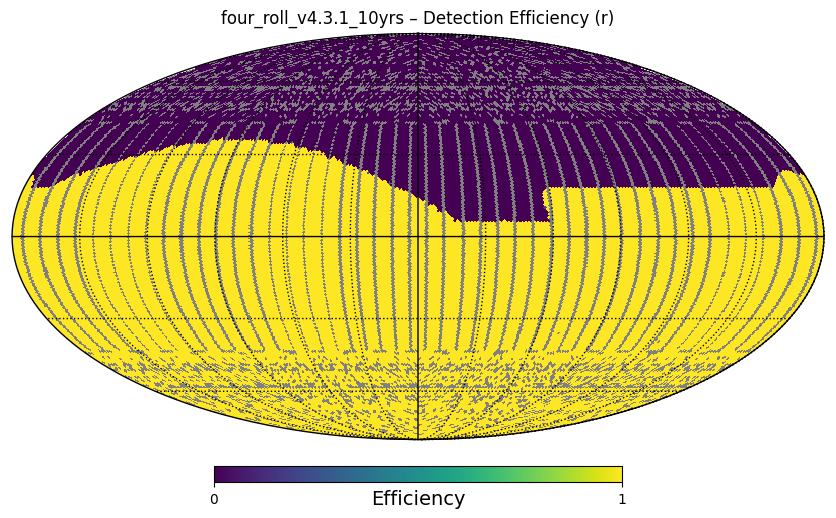

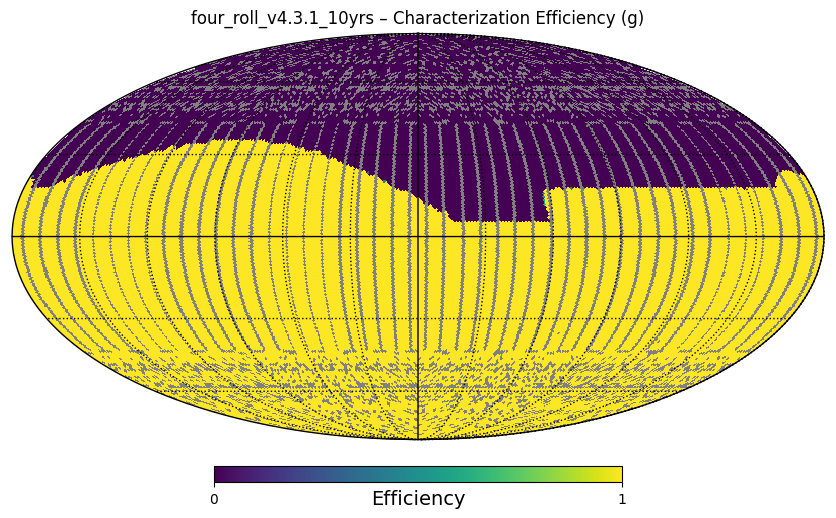

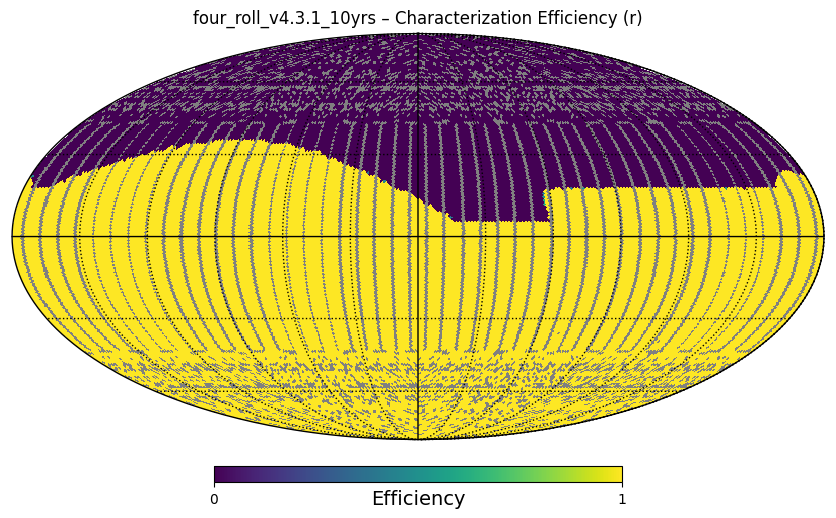

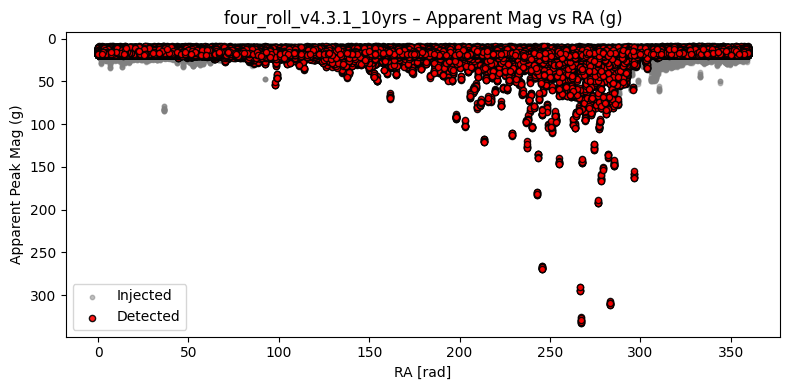

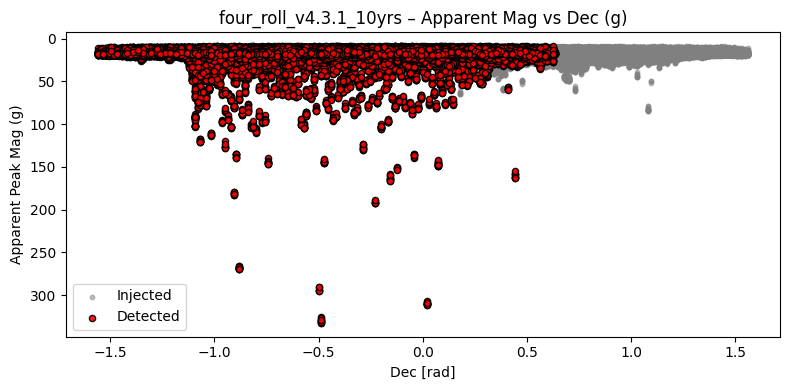

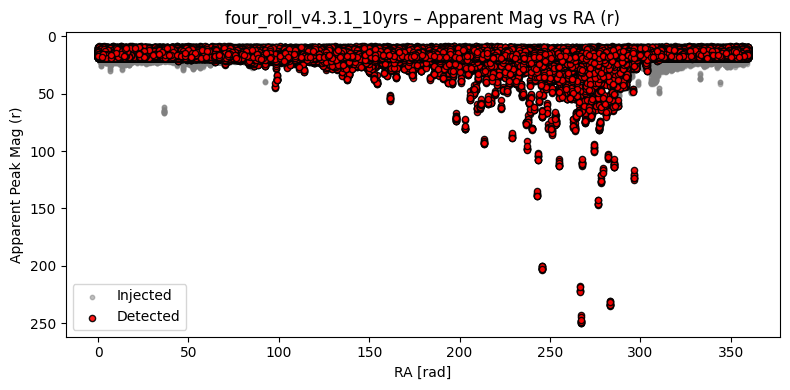

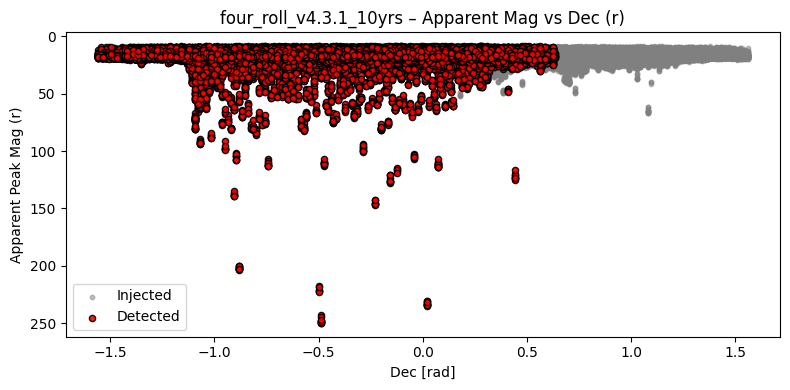


--- Running baseline_v4.3.1_10yrs ---
Out of 452770 simulated LFBOT events, Rubin detected 308263 under the baseline_v4.3.1_10yrs cadence.
Of those, each event was observed in an average of 2.0 ± 0.0 filters.


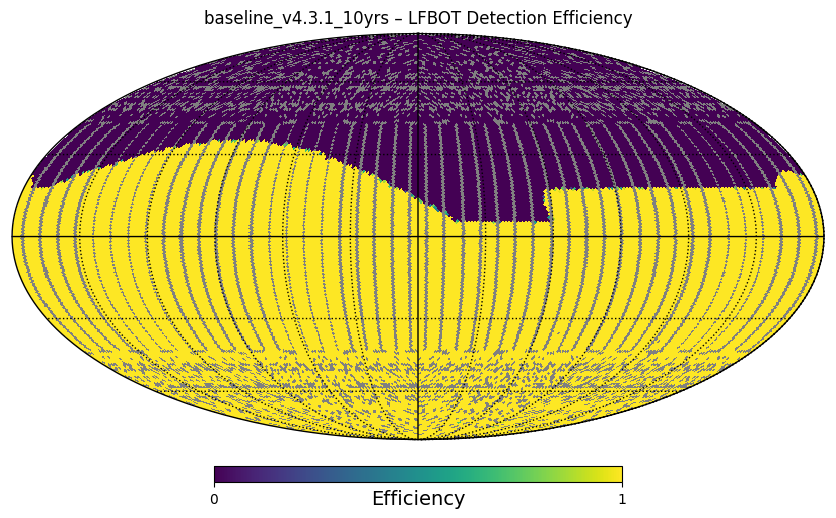

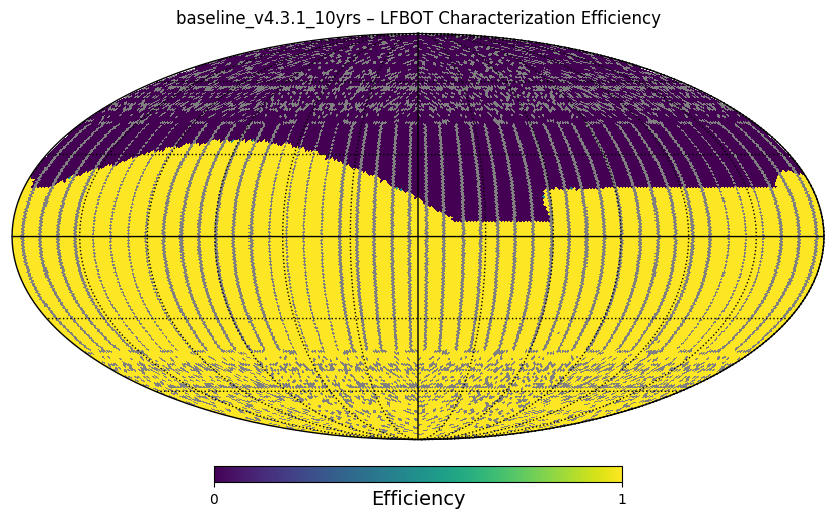

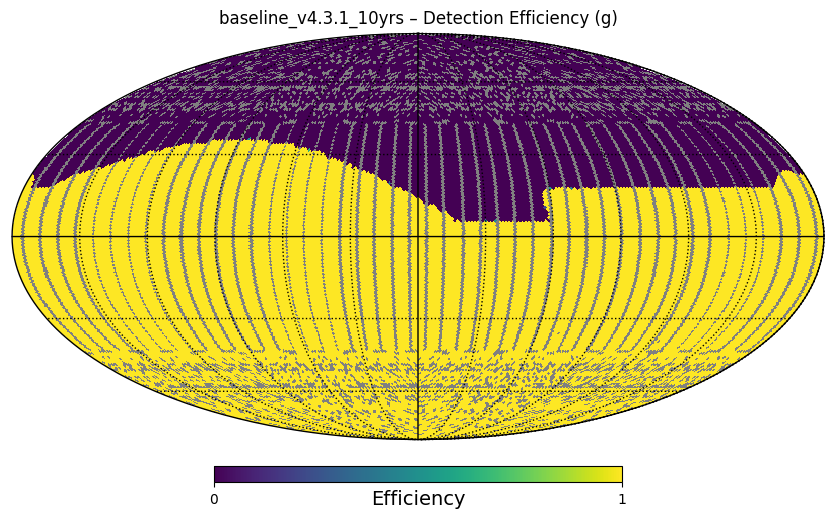

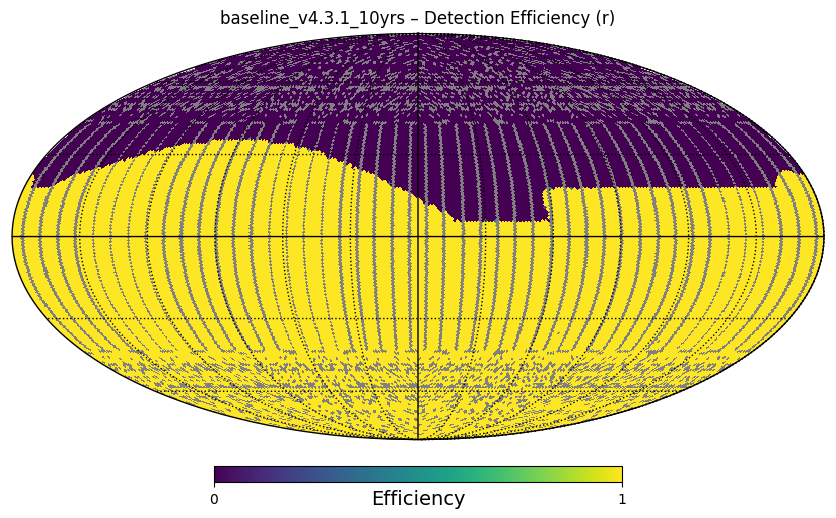

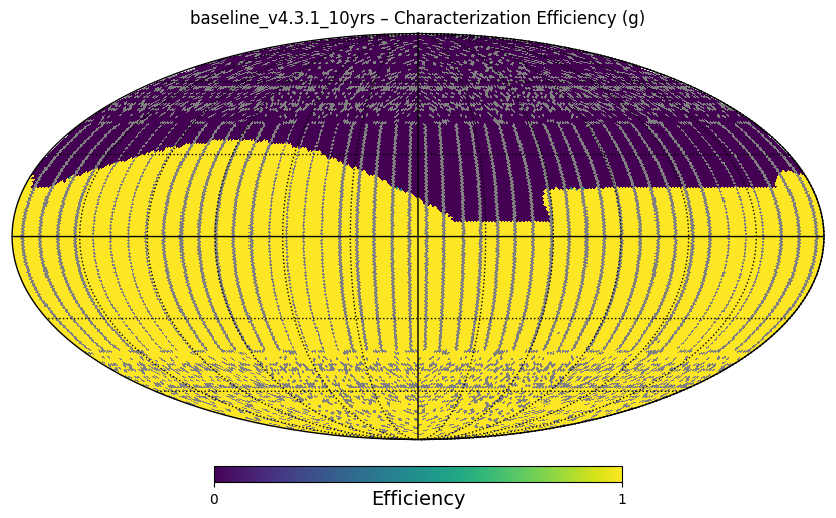

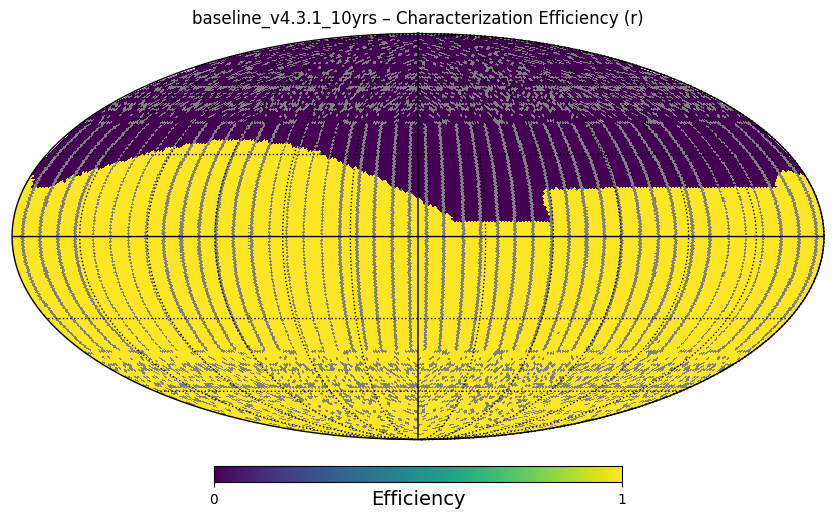

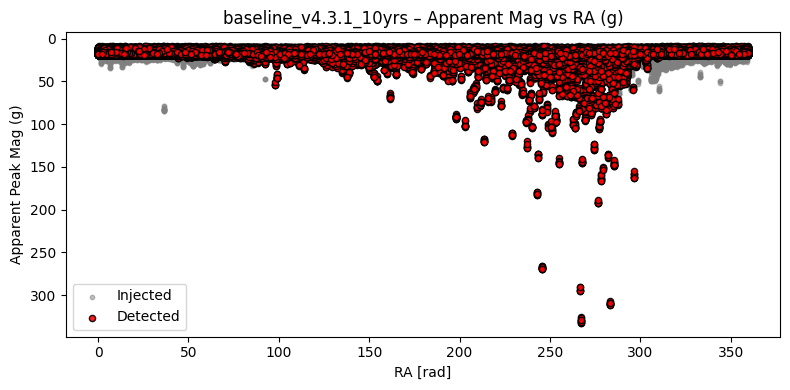

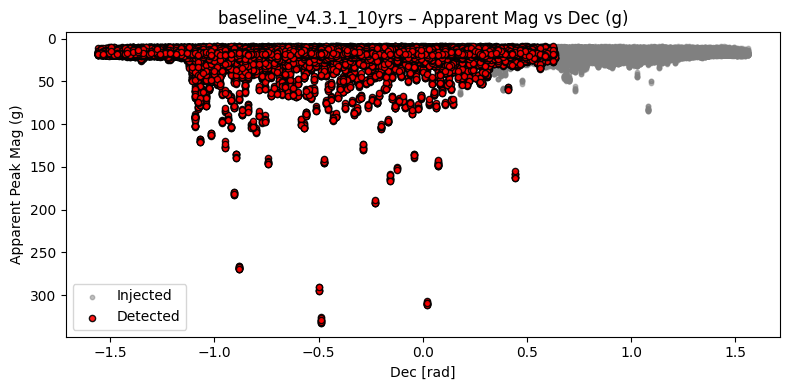

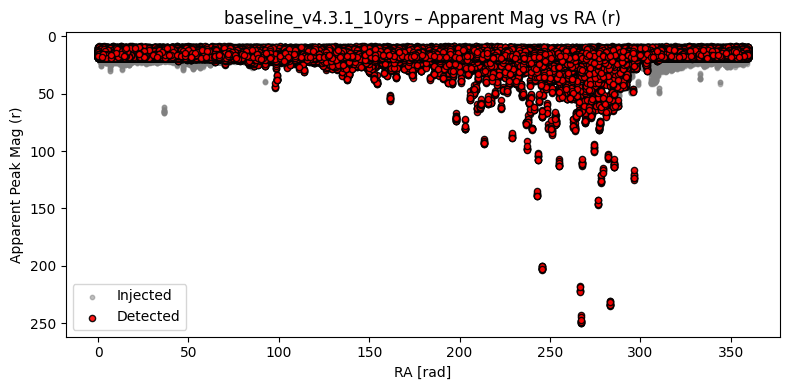

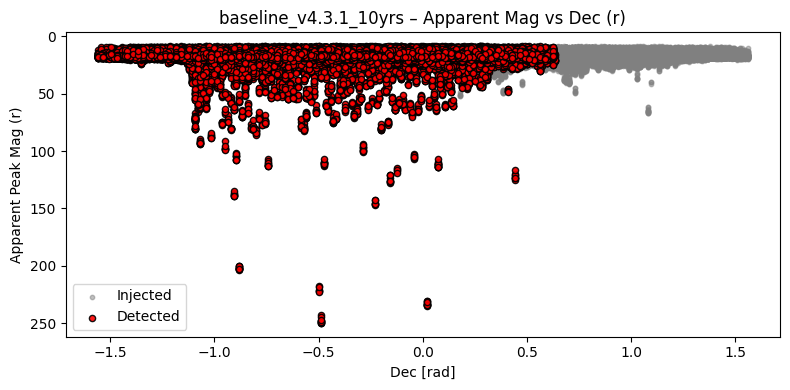

In [103]:
# --- Config ---
cadences = ['four_roll_v4.3.1_10yrs', 'baseline_v4.3.1_10yrs']
rate_str = "fixed"
filters = ['g', 'r']
out_dir = f"LFBOT_output/{rate_str}"
lfbot_templates_file = "LFBOT_templates.pkl"
lfbot_pop_file = os.path.join(out_dir, f"LFBOT_population_fixedpop.pkl")
dmin, dmax = 10, 600
rate_str = 1000
t_start, t_end = 1, 3652
os.makedirs(out_dir, exist_ok=True)

# --- Template Setup ---
if not os.path.exists(lfbot_templates_file):
    generateLFBOTTemplates(save_to=lfbot_templates_file)
shared_lc_model = LFBOT_LC(load_from=lfbot_templates_file)

# --- Population Setup ---
if not os.path.exists(lfbot_pop_file):
    slicer = generateLFBOTPopSlicer(
        t_start=t_start, t_end=t_end, seed=42,
        d_min=dmin, d_max=dmax, num_lightcurves=1000,
        save_to=lfbot_pop_file
    )
else:
    slicer = generateLFBOTPopSlicer(load_from=lfbot_pop_file)

n_events = len(slicer.slice_points['distance'])
first = 1

for cadence in cadences:
    print(f"\n--- Running {cadence} ---")
    runName = cadence
    opsdb = f"../{cadence}.db"
    outDir = os.path.join(out_dir, f"Metric_temp_{cadence}")
    os.makedirs(outDir, exist_ok=True)
    resultsDb = ResultsDb(out_dir=outDir)
   
    # Run per-filter detection metrics
    per_filter_metrics = OrderedDict()
    for filt in ['g', 'r']:
        single_detect_metric = LFBOTSingleFilterDetectMetric(metricName=f'LFBOT_Detect_{filt}',
                                                             filter_include=[filt],
                                                             lc_model=shared_lc_model)
        char_metric = LFBOTCharacterizeMetric(metricName=f'LFBOT_Characterize_{filt}',
                                              filter_include=[filt],
                                              lc_model=shared_lc_model)
        per_filter_metrics[f'LFBOT_Detect_{filt}'] = MetricBundle(single_detect_metric, slicer, '')
        per_filter_metrics[f'LFBOT_Characterize_{filt}'] = MetricBundle(char_metric, slicer, '')



    per_filter_metrics['LFBOT_Detect'] = MetricBundle(
        LFBOTDetectMetric(metricName='LFBOT_Detect', lc_model=shared_lc_model), slicer, '')
    per_filter_metrics['LFBOT_Characterize'] = MetricBundle(
        LFBOTCharacterizeMetric(metricName='LFBOT_Characterize', lc_model=shared_lc_model), slicer, '')

    

    pf_group = MetricBundleGroup(per_filter_metrics, opsdb, out_dir=outDir, results_db=resultsDb)
    pf_group.run_all()

    g_detected = per_filter_metrics['LFBOT_Detect_g'].metric_values
    r_detected = per_filter_metrics['LFBOT_Detect_r'].metric_values
    
    valid_g = ~g_detected.mask if hasattr(g_detected, 'mask') else np.ones(len(g_detected), dtype=bool)
    valid_r = ~r_detected.mask if hasattr(r_detected, 'mask') else np.ones(len(r_detected), dtype=bool)
    
    g_only = (g_detected == 1) & valid_g & ((r_detected != 1) | ~valid_r)
    r_only = (r_detected == 1) & valid_r & ((g_detected != 1) | ~valid_g)

    g_inclusive = (g_detected == 1) & valid_g
    r_inclusive = (r_detected == 1) & valid_r

    both = (g_detected == 1) & valid_g & (r_detected == 1) & valid_r
    
    #print(f"{cadence} – g-only: {np.sum(g_only)}, r-only: {np.sum(r_only)}, both: {np.sum(both)}")
    #print(f"{cadence} – total detected in g or r: {np.sum(g_only | r_only | both)}")


    values = per_filter_metrics["LFBOT_Detect"].metric_values
    if hasattr(values, 'mask'):
        mask = ~values.mask
    else:
        mask = np.ones(len(values), dtype=bool)
    
    detected_flags = (values == 1) & mask
        
    # Count how many filters detected each event
    n_filters_detected_per_event = (
        g_inclusive.astype(int) +
        r_inclusive.astype(int)
    )

    detected_mask = values == 1
    n_detected = np.sum(detected_mask)
    mean_filters = np.mean(n_filters_detected_per_event[detected_mask])
    std_filters = np.std(n_filters_detected_per_event[detected_mask])

    print(f"Out of {n_events} simulated LFBOT events, Rubin detected {n_detected} under the {cadence} cadence.")
    print(f"Of those, each event was observed in an average of {mean_filters:.1f} ± {std_filters:.1f} filters.")

    plot_sets = [
    ('LFBOT_Detect', 'LFBOT Detection Efficiency'),
    ('LFBOT_Characterize', 'LFBOT Characterization Efficiency'),
    ('LFBOT_Detect_g', 'Detection Efficiency (g)'),
    ('LFBOT_Detect_r', 'Detection Efficiency (r)'),
    ('LFBOT_Characterize_g', 'Characterization Efficiency (g)'),
    ('LFBOT_Characterize_r', 'Characterization Efficiency (r)')
    ]

    for metric_name, title in plot_sets:
        metric_values = per_filter_metrics[metric_name].metric_values
        nside = slicer.nside if hasattr(slicer, 'nside') else 64
        npix = hp.nside2npix(nside)
    
        injected_map = np.zeros(npix)
        detected_map = np.zeros(npix)
        ra_rad = slicer.slice_points['ra']
        dec_rad = slicer.slice_points['dec']
        theta = 0.5 * np.pi - dec_rad
        phi = ra_rad
        pix_inds = hp.ang2pix(nside, theta, phi)
    
        valid = ~metric_values.mask if hasattr(metric_values, 'mask') else np.ones(len(metric_values), dtype=bool)
        for i, pix in enumerate(pix_inds):
            injected_map[pix] += 1
            if (metric_values[i] == 1) and valid[i]:
                detected_map[pix] += 1
    
        eff_map = np.zeros(npix)
        valid_pix = injected_map > 0
        eff_map[valid_pix] = detected_map[valid_pix] / injected_map[valid_pix]
        eff_map[~valid_pix] = hp.UNSEEN
    
        hp.mollview(eff_map, title=f"{cadence} – {title}", unit='Efficiency', cmap='viridis')
        hp.graticule()
        plt.show()

    for filtername in ['g', 'r']:
        ras, decs, peak_mags, detected_flags = [], [], [], []
        ax1 = DustValues().ax1
    
        # Grab detection flag for each event in this filter
        metric_vals = per_filter_metrics[f"LFBOT_Detect_{filtername}"].metric_values
        valid = ~metric_vals.mask if hasattr(metric_vals, 'mask') else np.ones(len(metric_vals), dtype=bool)
        detected_flags = (metric_vals == 1) & valid
    
        # Loop through all events, regardless of detection
        for i in range(n_events):
            ra = slicer.slice_points['ra'][i]
            dec = slicer.slice_points['dec'][i]
            d = slicer.slice_points['distance'][i]
            ebv = slicer.slice_points['ebv'][i]
            file_indx = slicer.slice_points['file_indx'][i]
    
            # Use the full shared_lc_model without any filter_include logic
            m_peak = np.min(shared_lc_model.data[file_indx][filtername]['mag'])
            A = ax1[filtername] * ebv
            dm = 5 * np.log10(d * 1e6) - 5
            m_app = m_peak + dm + A
    
            ras.append(ra)
            decs.append(dec)
            peak_mags.append(m_app)
    
        # Convert to arrays
        ras = np.array(ras)
        decs = np.array(decs)
        peak_mags = np.array(peak_mags)
    
        # Plot RA
        plt.figure(figsize=(8, 4))
        plt.scatter(ras, peak_mags, c='gray', s=10, label='Injected', alpha=0.5)
        plt.scatter(ras[detected_flags], peak_mags[detected_flags], c='red', s=20, label='Detected',
                    alpha=0.9, edgecolors='black')
        plt.xlabel("RA [rad]")
        plt.ylabel(f"Apparent Peak Mag ({filtername})")
        plt.title(f"{cadence} – Apparent Mag vs RA ({filtername})")
        plt.gca().invert_yaxis()
        plt.legend()
        plt.tight_layout()
        plt.show()
    
        # Plot Dec
        plt.figure(figsize=(8, 4))
        plt.scatter(decs, peak_mags, c='gray', s=10, label='Injected', alpha=0.5)
        plt.scatter(decs[detected_flags], peak_mags[detected_flags], c='red', s=20, label='Detected',
                    alpha=0.9, edgecolors='black')
        plt.xlabel("Dec [rad]")
        plt.ylabel(f"Apparent Peak Mag ({filtername})")
        plt.title(f"{cadence} – Apparent Mag vs Dec ({filtername})")
        plt.gca().invert_yaxis()
        plt.legend()
        plt.tight_layout()
        plt.show()

